# Project6 - AllLife Bank Customer Segmentation

## Problem statement

* The marketing team of The AllLife Bank proposes to run personalized campaigns to target new customers as well as upsell to existing customers. 


* The Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster.

## Objective

* To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms. 

* To provide recommendations to the bank on how to better market to and service these customers.

 

## Data

**Credit_Card_Customer_Data.xlsx ( sheet : Sheet1 )**

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Loading libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

## Loading and exploring the dataset

### Read the dataset.

In [2]:
raw_data = pd.read_excel(
    open("Credit_Card_Customer_Data.xlsx", "rb"), sheet_name="Sheet1"
)

<IPython.core.display.Javascript object>

In [3]:
# copying data to another varaible to avoid any changes to original data
df = raw_data.copy()

<IPython.core.display.Javascript object>

In [4]:
# checking the shape of the data
df.shape

(660, 7)

<IPython.core.display.Javascript object>

* The dataset has 660 rows and 7 columns

### View the first, last and random 5 rows of the dataset.

In [5]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [6]:
df.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


<IPython.core.display.Javascript object>

In [7]:
df.sample(n=5, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3


<IPython.core.display.Javascript object>

### Check duplicates.

In [8]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [9]:
# check dupilcates without Sl_No
df.drop(["Sl_No"], axis=1).duplicated().sum()  ## no data change

0

<IPython.core.display.Javascript object>

* No duplicate was found.

### Check the data types of the columns for the dataset.

In [10]:
# checking column datatypes and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

* There are no missing values in the data.
* `Sl_No` and `Customer Key` will not be needed for analysis.

In [11]:
df.drop(["Sl_No", "Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Summary of the dataset.

In [12]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


<IPython.core.display.Javascript object>

* The average of `Avg_Credit_Limit` is 34574 and the median is 18000.
* The average of `Total_Credit_Cards` is 4.70.
* The average of `Total_visits_bank` is 2.40.
* The average of `Total_vitis_online` is 2.60.
* The average of `Total_calls_made` is 3.58.

## EDA - Univariate analysis

### Functions

In [13]:
def hist_box(data, feature, figsize=(12, 7), kde=False, bins=None):
    """

  show histogram & boxplot at once

  data : dataframe
  feature : column name
  figsize ; figure size (default (12,7))
  kde : whether to show density curve ( default false )
  bins : bin numbers ( default None)

  """

    fs, (ax_box, ax_hist) = plt.subplots(
        nrows=2, sharex=True, figsize=(12, 7), gridspec_kw={"height_ratios": (0.3, 0.7)}
    )
    sns.boxplot(data=data, ax=ax_box, x=feature, showmeans=True, color="violet")
    if bins:
        sns.histplot(data=data, ax=ax_hist, x=feature, bins=bins, kde=kde)
    else:
        sns.histplot(data=data, ax=ax_hist, x=feature, kde=kde)
    ax_hist.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  ## draw a green dotted line of mean
    ax_hist.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  ## draw a black straight line of median
    plt.show()

<IPython.core.display.Javascript object>

In [14]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None, rotation=90):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=rotation, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.2f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

### Observations on Avg_Credit_Limit

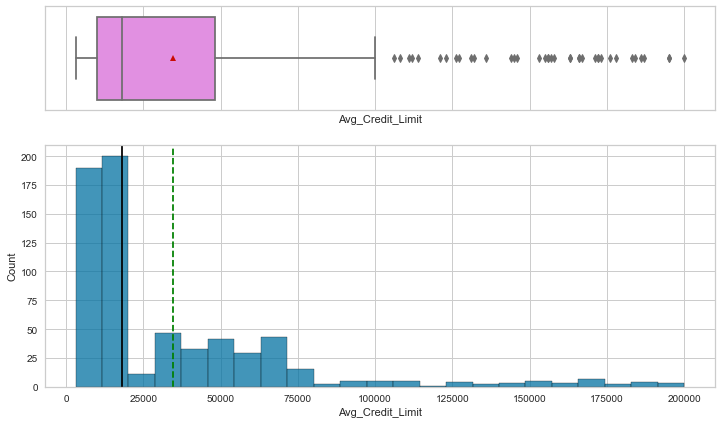

<IPython.core.display.Javascript object>

In [15]:
hist_box(df, "Avg_Credit_Limit")

* Various `Avg_Credit_Limit` ranges were observed and many outliers outside the upper whisker were observed.
* A highly right-skewed distribution was observed.

### Observations on Total_Credit_Cards

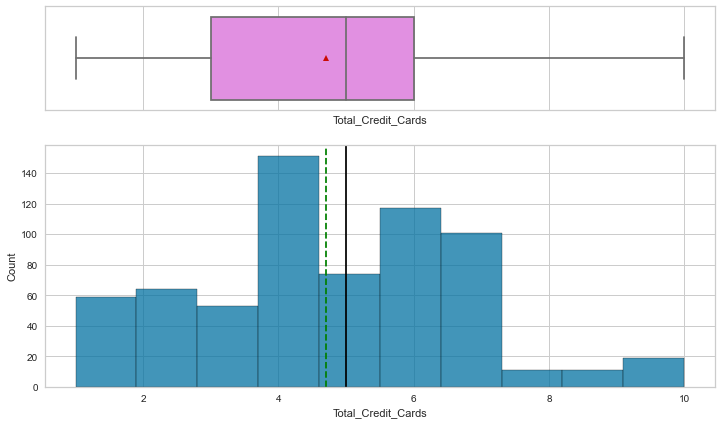

<IPython.core.display.Javascript object>

In [16]:
hist_box(df, "Total_Credit_Cards", bins=10)

* The median of `Total_Credit_Cards` is 5 and the average is 4.7.
* There are no outliers.

### Observations on Total_visits_bank

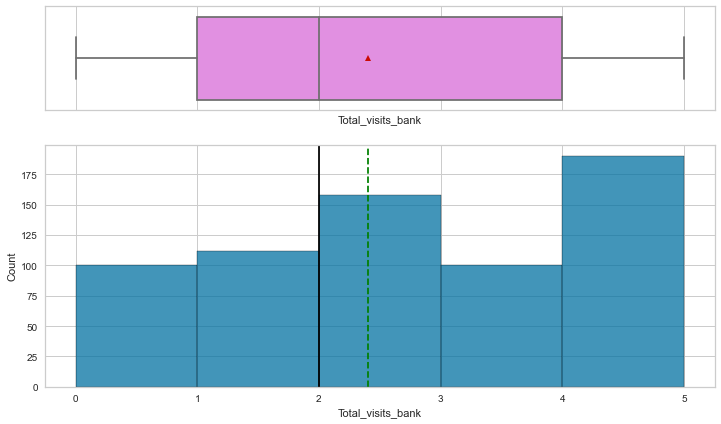

<IPython.core.display.Javascript object>

In [17]:
hist_box(df, "Total_visits_bank", bins=5)

* The median of `Total_visits_bank` is 2 and the average is 2.4.
* There are no outliers.

### Observations on Total_visits_online

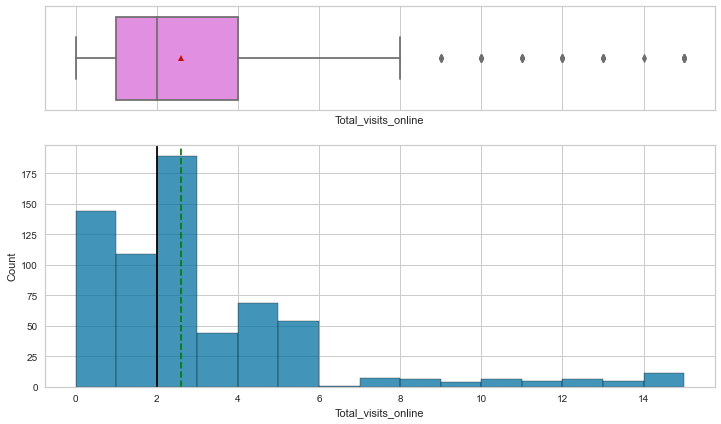

<IPython.core.display.Javascript object>

In [18]:
hist_box(df, "Total_visits_online", bins=15)

* The median of `Total_visits_online` is 2 and the average is 2.6.
* Some outliers outside the upper whisker were observed.
* A right-skewed distribution was observed.

### Observations on Total_calls_made

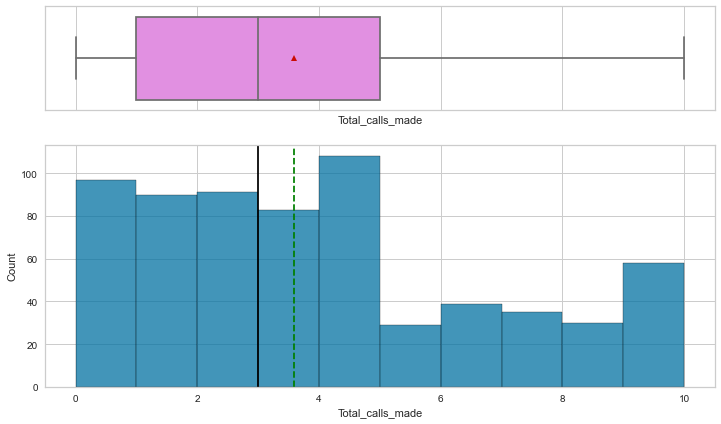

<IPython.core.display.Javascript object>

In [19]:
hist_box(df, "Total_calls_made", bins=10)

* The median of `Total_visits_bank` is 3 and the average is 3.6.
* There are no outliers.

## EDA - Bivariate analysis

### Functions

In [20]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [21]:
# function to plot stacked bar chart


def stacked_barplot(
    data,
    predictor,
    target,
    legend=True,
    annot=False,
    rotation=0,
    xticksize=11,
    xlabsize=13,
):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    legend : show on/off legend
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))

    if legend == True:
        plt.legend(
            loc="lower left", frameon=False,
        )
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    elif legend == False:
        plt.legend([], [], frameon=False)
    plt.xticks(rotation=rotation, fontsize=xticksize)
    ax.set_xlabel(ax.get_xlabel(), size=xlabsize)
    plt.show()

<IPython.core.display.Javascript object>

### Pairplot

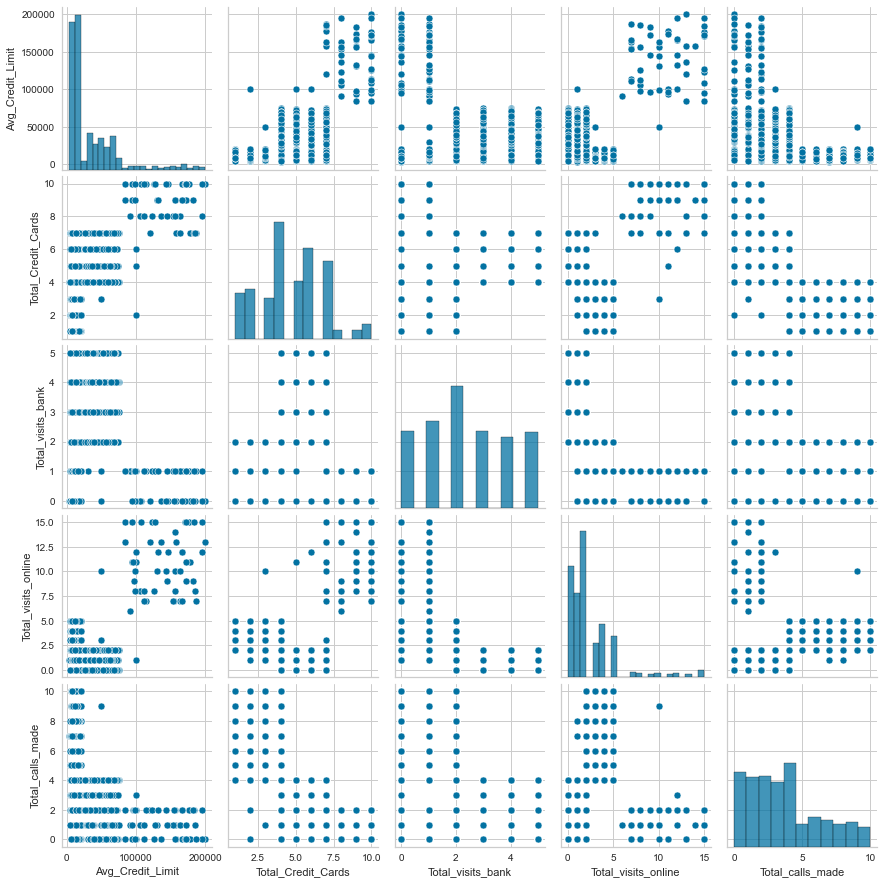

<IPython.core.display.Javascript object>

In [22]:
sns.pairplot(df,hue = 'Exited',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

### Correlation heatmap

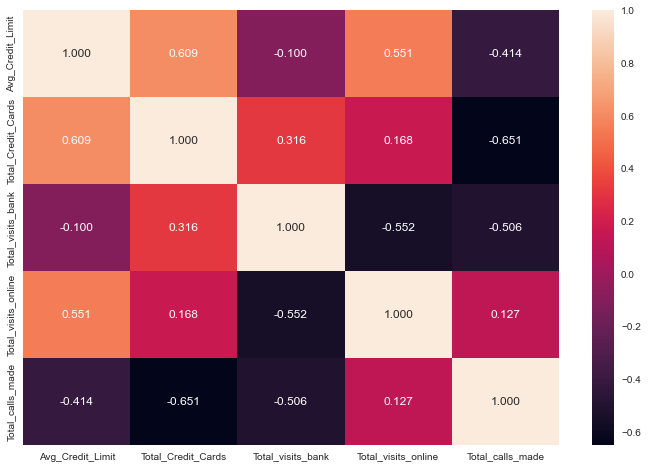

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".3f")
plt.show()

* `Avg_Credit_Limit` and `Total_Credit_Cards` show a positive correlation. ( Correlation = 0.609 )
* `Avg_Credit_Limit` and `Total_visits_online` show a positive correlation. ( Correlation = 0.551 )
* `Avg_Credit_Limit` and `Total_calls_made` show a negative correlation. ( Correlation = -0.414 )
* `Total_Credit_Cards` and `Total_visits_bank` show a positive correlation. ( Correlation = 0.316 )
* `Total_Credit_Cards` and `Total_calls_made` show a negative correlation. ( Correlation = -0.651 )
* `Total_visits_bank` and `Total_calls_online` show a negative correlation. ( Correlation = -0.552 )
* `Total_visits_bank` and `Total_calls_made` show a negative correlation. ( Correlation = -0.506 )

### Avg_Credit_Limit vs Total_Credit_Limit

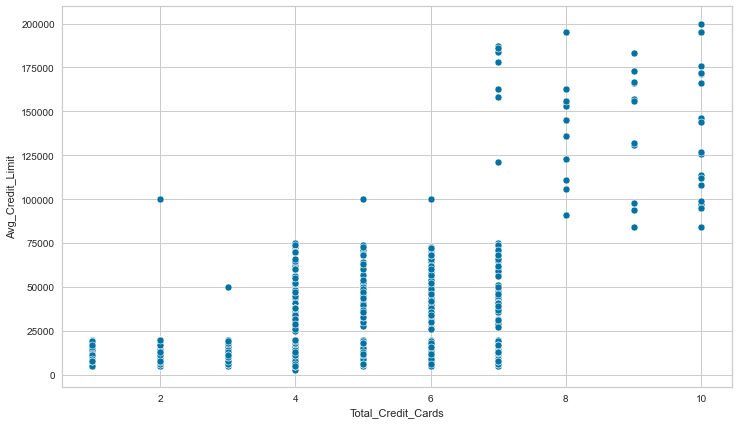

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Avg_Credit_Limit", x="Total_Credit_Cards")
plt.show()

* A tendency was observed to increase the credit limit as customers had more credit cards.

### Avg_Credit_Limit vs Total_visits_bank

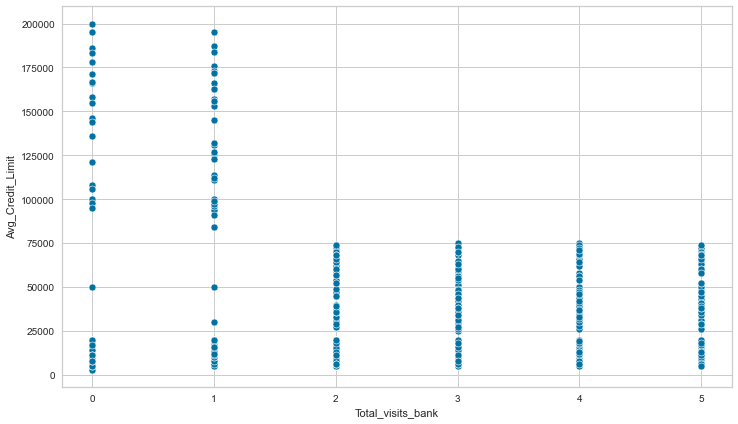

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Avg_Credit_Limit", x="Total_visits_bank")
plt.show()

* Customers with a credit limit of 80,000 or more have less than 2 bank visits per year.

### Avg_Credit_Limit vs Total_visits_online

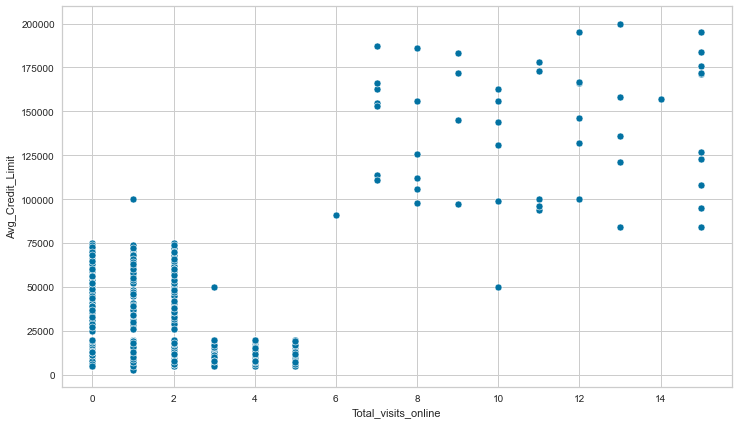

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Avg_Credit_Limit", x="Total_visits_online")
plt.show()

* Customers who use online banks more than 6 times a year have higher credit limits than those who do not.

### Avg_Credit_Limit vs Total_calls_made

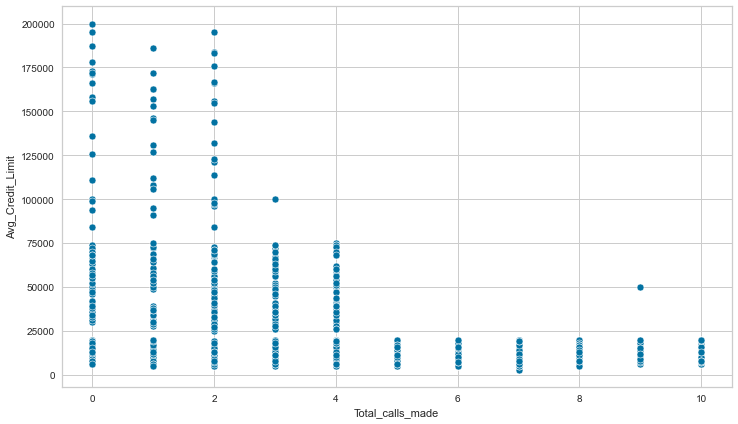

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Avg_Credit_Limit", x="Total_calls_made")
plt.show()

* It was observed that the higher the credit limit of the customers, the less frequent the number of calls to the bank per year.


### Total_Credit_Cards vs Total_visits_bank

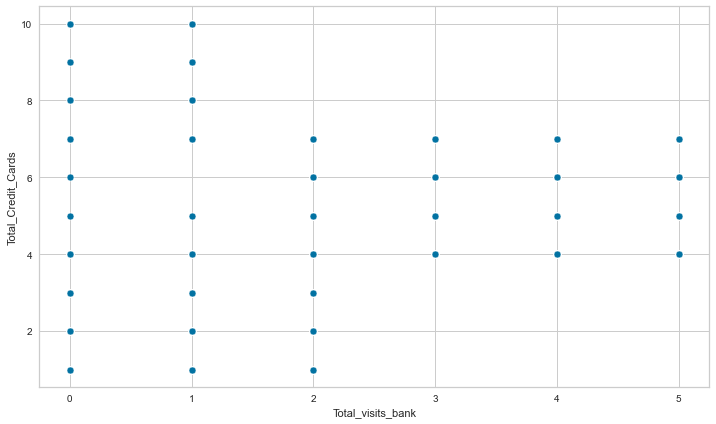

<IPython.core.display.Javascript object>

In [28]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_Credit_Cards", x="Total_visits_bank")
plt.show()

* Customers who visit the bank more than three times a year have a card.
* Customers with eight or more cards visit the bank less than twice a year.

### Total_Credit_Cards vs Total_visits_online

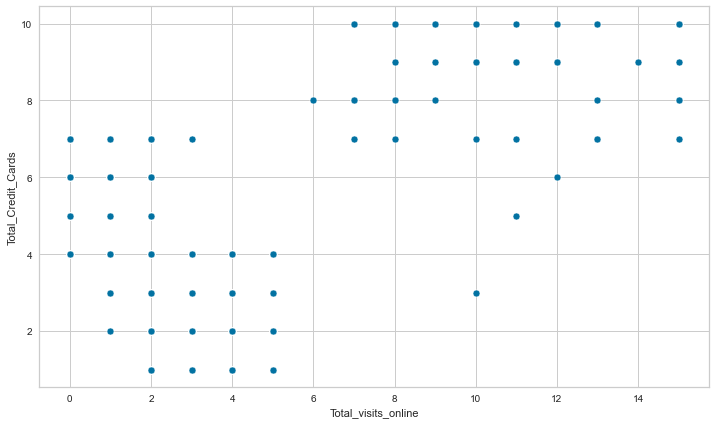

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_Credit_Cards", x="Total_visits_online")
plt.show()

* A tendency was observed that customers with many cards had a high number of annual online visits.

### Total_Credit_Cards vs Total_calls_made

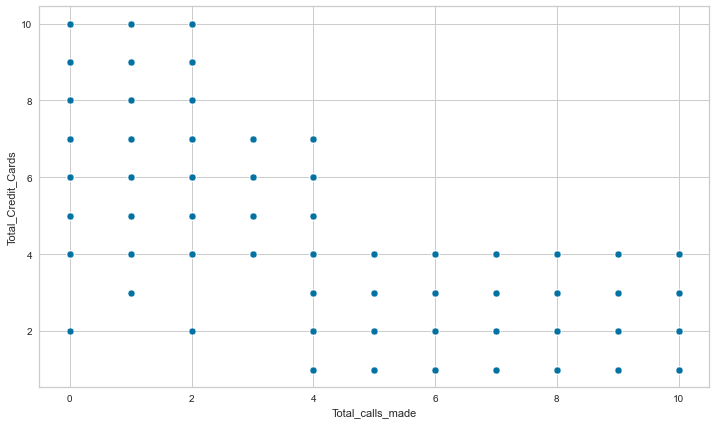

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_Credit_Cards", x="Total_calls_made")
plt.show()

* The more cards customers have, the less frequently they call the bank.

### Total_visits_bank vs Total_visits_online

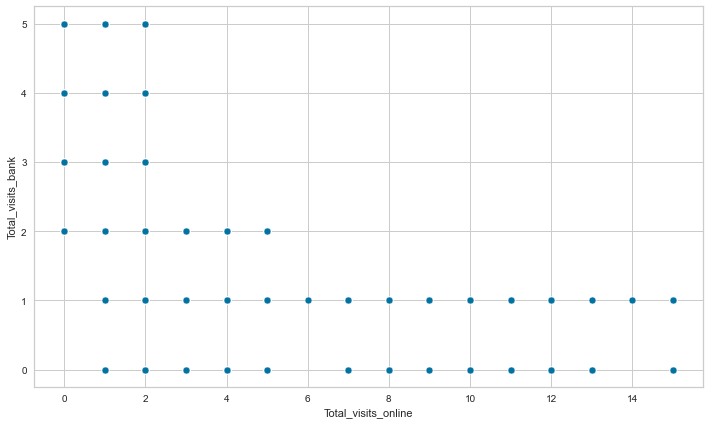

<IPython.core.display.Javascript object>

In [31]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_visits_bank", x="Total_visits_online")
plt.show()

* Customers who visit the bank more have fewer online visits.

### Total_visits_bank vs Total_calls_made

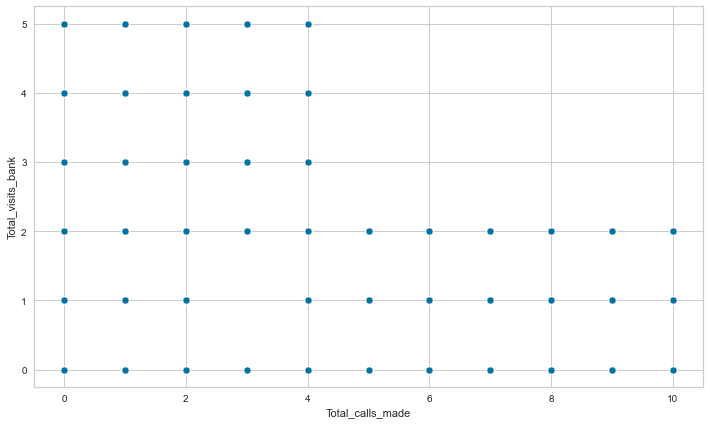

<IPython.core.display.Javascript object>

In [32]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_visits_bank", x="Total_calls_made")
plt.show()

* Customers who called the bank more than 4 times a year visited the bank less than 3 times a year.


### Total_visits_online vs Total_calls_made

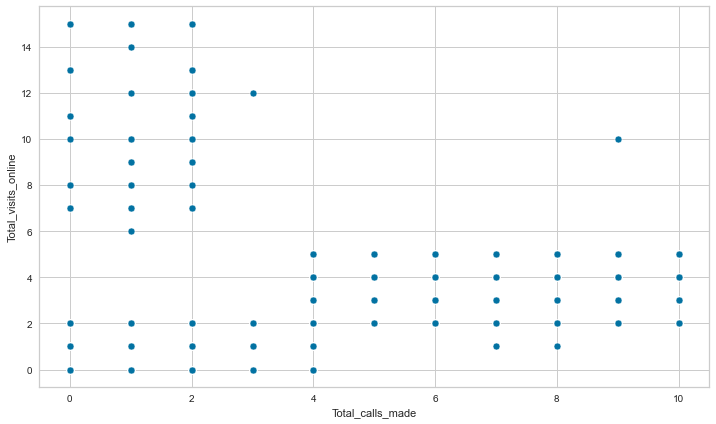

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, y="Total_visits_online", x="Total_calls_made")
plt.show()

* Customers who call the bank more have fewer online visits.

## Key Observations from EDA

* A tendency was observed to increase the credit limit as customers had more credit cards.
* The higher the credit limit of the customers, the less frequent the number of calls to the bank per year.
* Customers with more cards have a higher number of annual online visits.
* Customers who call the bank more have fewer online visits.

## Data pre-processing

### Checking for Null Values

In [34]:
df.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

* The data set has no missing values.

### Outlier treatment

In [35]:
# IQR defining - train
Q1 = df.quantile(0.25)  # finding the 25th percentile.
Q3 = df.quantile(0.75)  # finding the 75th percentile.
IQR = Q3 - Q1  # inter quantile range (IQR)
lower = Q1 - 1.5 * IQR  # lower whisker
upper = Q3 + 1.5 * IQR  # upper whisker

<IPython.core.display.Javascript object>

In [36]:
upper

Avg_Credit_Limit       105000.0
Total_Credit_Cards         10.5
Total_visits_bank           8.5
Total_visits_online         8.5
Total_calls_made           11.0
dtype: float64

<IPython.core.display.Javascript object>

In [37]:
(
    (df.select_dtypes(include=["float64", "int64"]) < lower)
    | (df.select_dtypes(include=["float64", "int64"]) > upper)
).sum() / len(df) * 100

Avg_Credit_Limit       5.909091
Total_Credit_Cards     0.000000
Total_visits_bank      0.000000
Total_visits_online    5.606061
Total_calls_made       0.000000
dtype: float64

<IPython.core.display.Javascript object>

* During EDA process, in the scatterplot of `Avg_Credit_Limit` and `Total_visits_online`, the group corresponding to the outlier was clearly observed, so no outlier treatment was performed.

### Scaling

In [38]:
sc = StandardScaler()
scaled_df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)  # applying z-score
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

## K-means clustering

### Finding the optimal number of clusters

#### Elbow method

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9091362001500471
Number of Clusters: 8 	Average Distortion: 0.8891531386814516
Number of Clusters: 9 	Average Distortion: 0.8668058282254026
Number of Clusters: 10 	Average Distortion: 0.8468952776763298


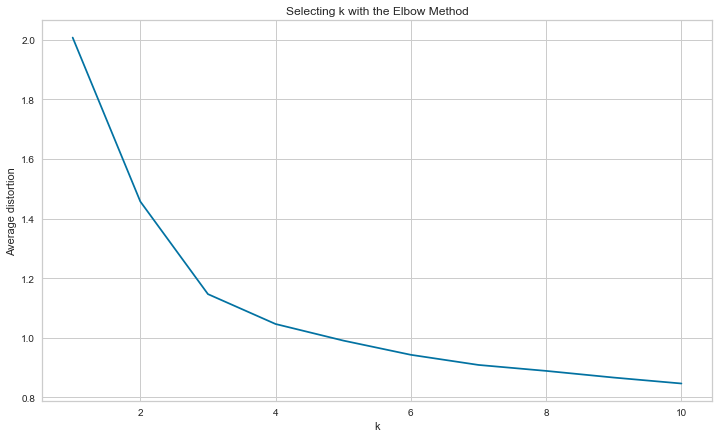

<IPython.core.display.Javascript object>

In [39]:
# Finding optimal no. of clusters

clusters = range(1, 10 + 1)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction = model.predict(scaled_df)
    distortion = (
        sum(np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.figure(figsize=(12, 7))
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

* With the k value of 3, the bend is coming out clearly, so appropriate value for k seems to be 3.

#### Silhouette scores

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.25545029453623114)
For n_clusters = 7, the silhouette score is 0.2481290278388238)
For n_clusters = 8, the silhouette score is 0.2401722628527782)
For n_clusters = 9, the silhouette score is 0.22023446208126946)


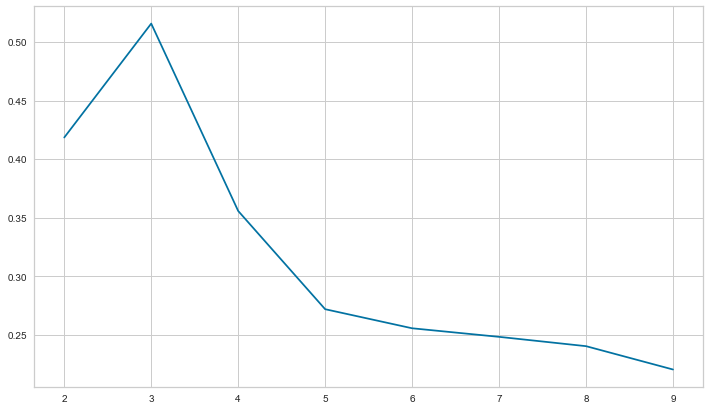

<IPython.core.display.Javascript object>

In [40]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.figure(figsize=(12, 7))
plt.plot(cluster_list, sil_score)
plt.show()

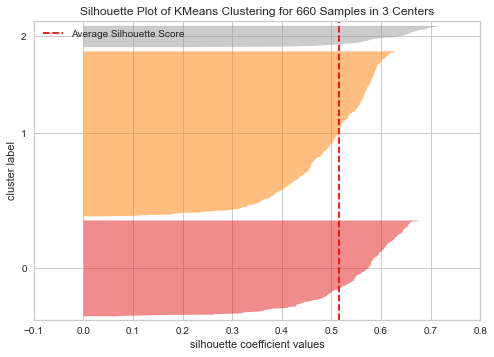

<IPython.core.display.Javascript object>

In [41]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(scaled_df)
visualizer.show()

del SilhouetteVisualizer

* Silhouette score for 3 is higher than others, so appropriate value for k seems to be 3.

### Modeling

In [42]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(scaled_df)

KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

In [43]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster profiling

In [44]:
kmean_cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [45]:
kmean_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536
1,33782.383420,5.515544,3.489637,0.981865,2.000000
2,141040.000000,8.740000,0.600000,10.900000,1.080000


<IPython.core.display.Javascript object>

In [46]:
# counts of each clustering
df[["K_means_segments"]].value_counts()

K_means_segments
1                   386
0                   224
2                    50
dtype: int64

<IPython.core.display.Javascript object>

In [47]:
# percentage
df[["K_means_segments"]].value_counts() / df["K_means_segments"].count() * 100

K_means_segments
1                   58.484848
0                   33.939394
2                    7.575758
dtype: float64

<IPython.core.display.Javascript object>

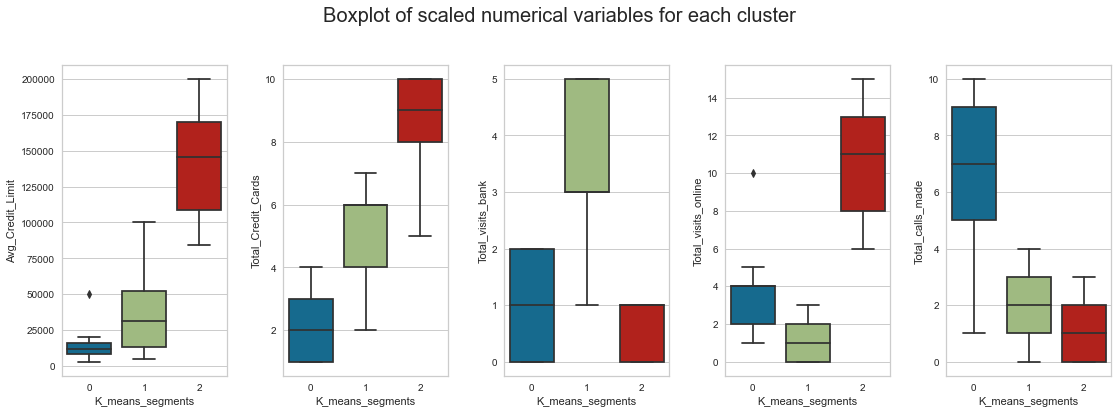

<IPython.core.display.Javascript object>

In [48]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i], y=df[num_col[i]], x=df["K_means_segments"],
    )
fig.tight_layout(pad=2.0)

## Hierarchical clustering

### Finding the optimal method and the number of clusters

#### Cophenetic correlation

In [49]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "weighted", "ward"]

for dm in distance_metrics:
    for lm in linkage_methods:
        if lm == "ward" or lm == "centroid":
            if (
                not dm == "euclidean"
            ):  # ward or centroid linkage works only with euclidean distrance
                continue
        Z = linkage(scaled_df, metric=dm, method=lm)
        c, coph_dist = cophenet(Z, pdist(scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, format(c, "0.3f")
            )
        )

Cophenetic correlation for Euclidean distance and single linkage is 0.898.
Cophenetic correlation for Euclidean distance and complete linkage is 0.884.
Cophenetic correlation for Euclidean distance and average linkage is 0.910.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.907.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.907.
Cophenetic correlation for Euclidean distance and ward linkage is 0.757.
Cophenetic correlation for Chebyshev distance and single linkage is 0.814.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.857.
Cophenetic correlation for Chebyshev distance and average linkage is 0.909.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.905.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.865.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.610.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.842.
Cophen

<IPython.core.display.Javascript object>

* Highest cophenetic correlation is 0.910, which is obtained with Euclidean distance and average linkage.

#### Dendrograms for different linkage methods

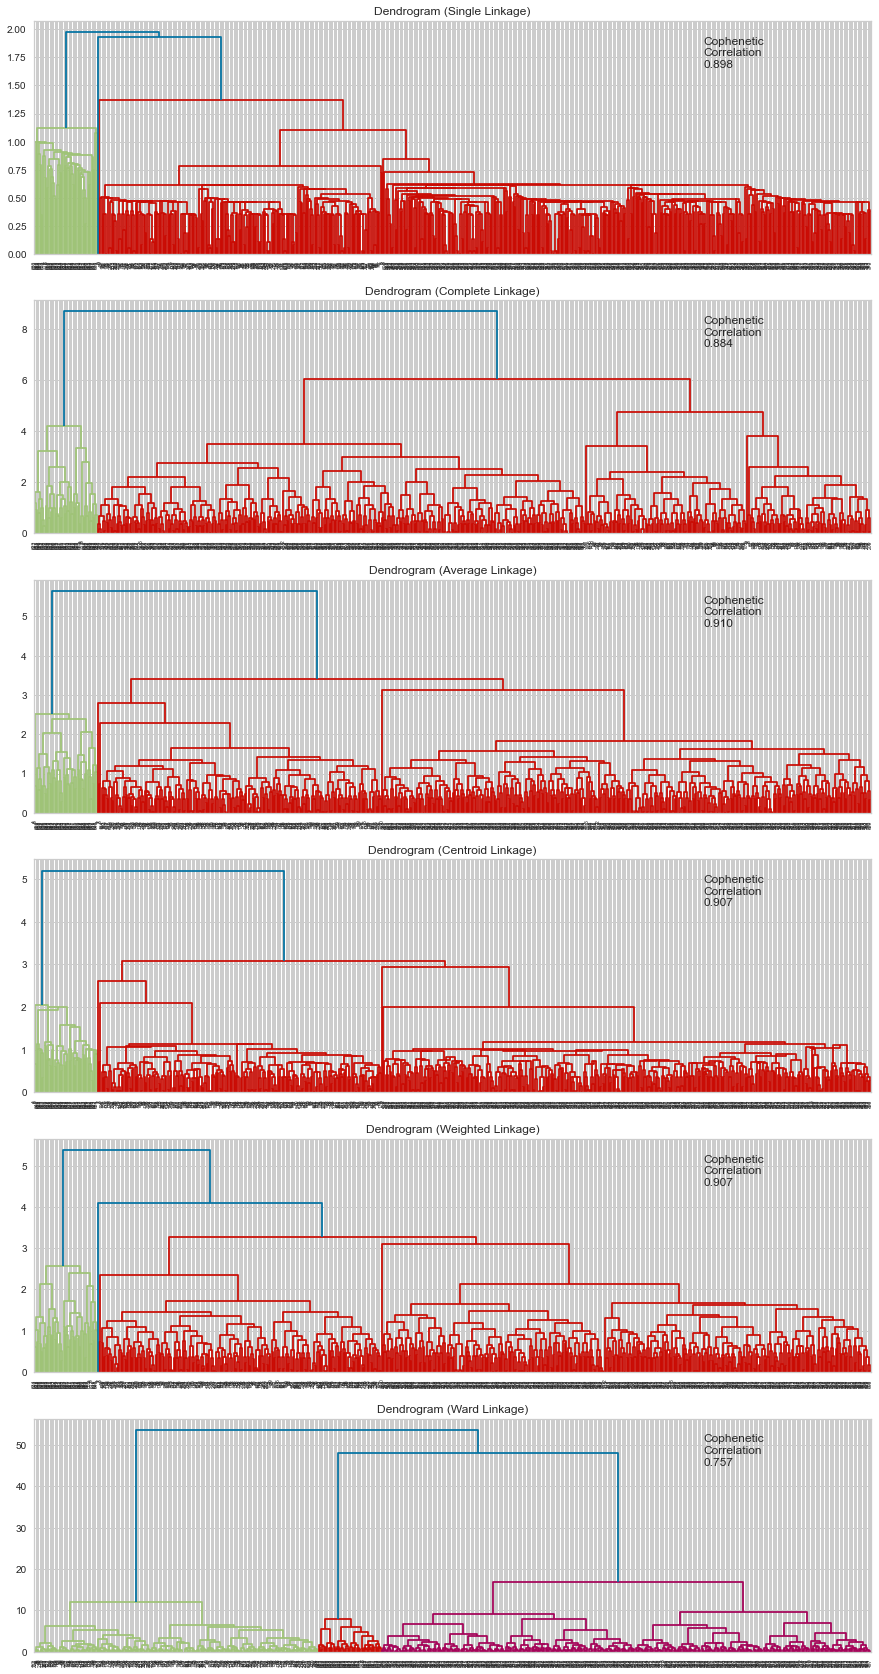

<IPython.core.display.Javascript object>

In [50]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "weighted", "ward"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 5 * len(linkage_methods)))

for i in range(len(linkage_methods)):
    lm = linkage_methods[i]
    Z = linkage(scaled_df, metric="euclidean", method=lm)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({lm.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.3f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

* The dendrogram for average linkage had the highest cophenetic correlation.

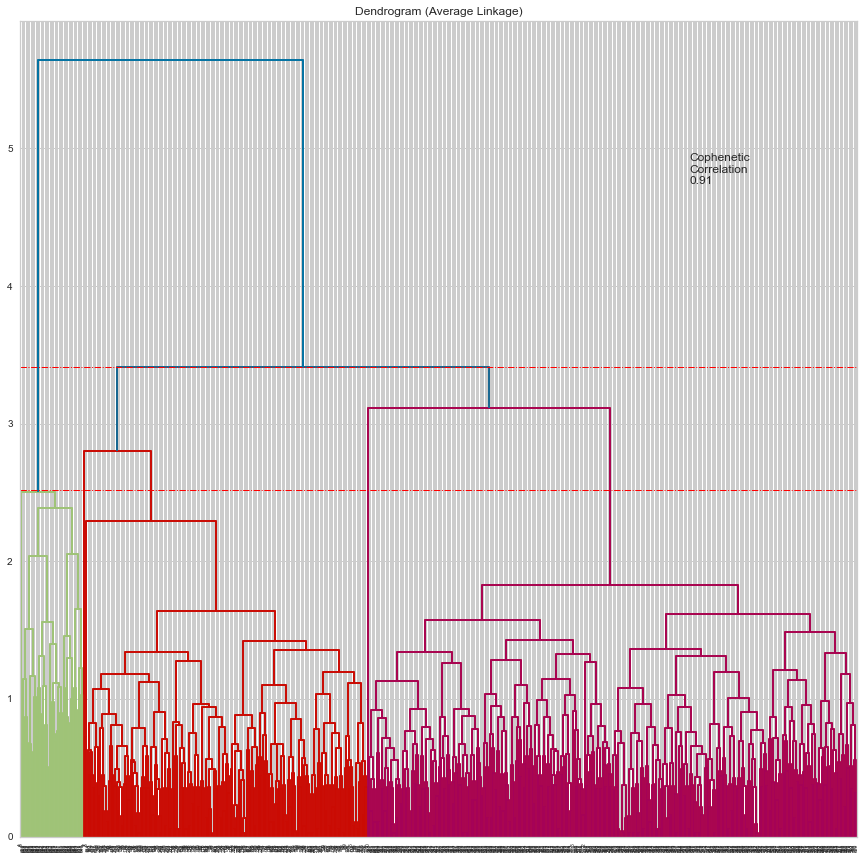

<IPython.core.display.Javascript object>

In [51]:
# list of linkage methods
linkage_methods = ["average"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=3.4)
plt.axhline(y=3.41, c="red", lw=1, linestyle="dashdot")
plt.axhline(y=2.52, c="red", lw=1, linestyle="dashdot")

* The maximum height is 2, but if the number of clusters is set to 2, the result will be highly biased.
* The number of clusters can be set from 3 to 5, but when 4 or 5 is set, the number of data points in some clusters becomes too small, so 3 appears to be the appropriate number of clusters from the dendrogram for average linkage.

### Modeling

In [52]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [53]:
# adding hierarchical cluster labels to the original and scaled dataframes

df["HC_segments"] = HCmodel.labels_
scaled_df["HC_segments"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster profiling

In [54]:
hc_profile = df.drop(["K_means_segments"], axis=1).groupby("HC_segments").mean()

<IPython.core.display.Javascript object>

In [55]:
hc_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12174.107143,2.410714,0.933036,3.553571,6.870536


<IPython.core.display.Javascript object>

In [56]:
# counts of each clustering
df[["HC_segments"]].value_counts()

HC_segments
0              386
2              224
1               50
dtype: int64

<IPython.core.display.Javascript object>

In [57]:
# percentage
df[["HC_segments"]].value_counts() / df["HC_segments"].count() * 100

HC_segments
0              58.484848
2              33.939394
1               7.575758
dtype: float64

<IPython.core.display.Javascript object>

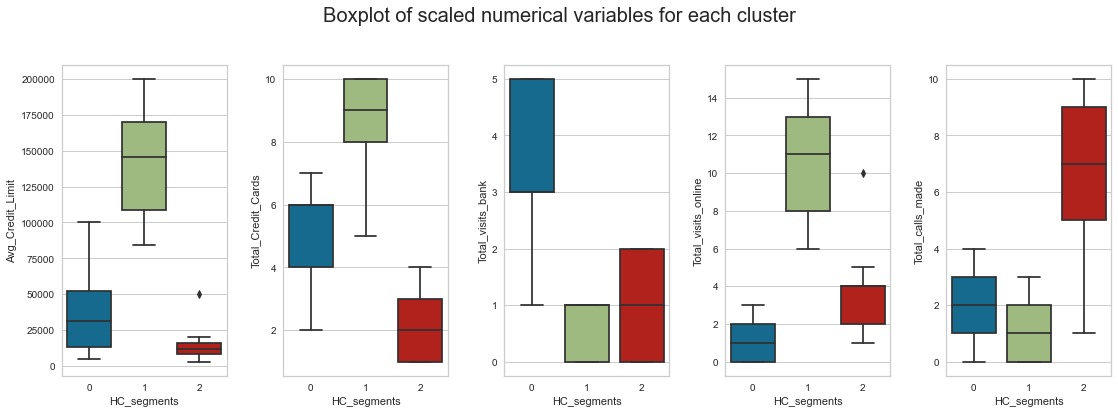

<IPython.core.display.Javascript object>

In [58]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for i in range(5):
    sns.boxplot(
        ax=axes[i], y=df[num_col[i]], x=df["HC_segments"],
    )
fig.tight_layout(pad=2.0)

## K-means vs Hierarchical Clustering

In [59]:
df.groupby(["K_means_segments", "HC_segments"]).mean()

,,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,HC_segments,,,,,
0,2,12174.107143,2.410714,0.933036,3.553571,6.870536
1,0,33782.383420,5.515544,3.489637,0.981865,2.000000
2,1,141040.000000,8.740000,0.600000,10.900000,1.080000


<IPython.core.display.Javascript object>

* The results of Kmeans clustering and hierarchical clustering were exactly the same.
* Cluster 0 of Hierarchical clustering is Cluster 1 of K means clustering.
* Cluster 1 of Hierarchical clustering is Cluster 2 of K means clustering.
* Cluster 2 of Hierarchical clustering is Cluster 0 of K means clustering.

## Summary of cluster profiling

**The following summary is based on the cluster name of Hierarchical clustering.** 

**Cluster 0**
 - About 58% of customers belong to this group.
 - Credit limit and the number of credit cards held is moderate.
 - Online banking usage and is low.
 - The number of direct bank visits is high.
 - The number of call to the bank is low.

**Cluster 1**
 - About 8% of customers belong to this group.
 - Credit limit and the number of credit cards held is high.
 - Online banking usage is high.
 - The number of direct bank visits is low.
 - The number of call to the bank is low.

**Cluster 2**
 - About 34% of customers belong to this group.
 - Credit limit and the number of credit cards held is low
 - Online banking usage is moderate.
 - The number of direct bank visits is low.
 - The number of call to the bank is high.

## Conclusion

* Customers who prefer online banking use credit cards more and have fewer direct bank visits or phone calls.


* The customer group most helpful to the bank's profit increase is the group customers who mainly use online banking.


* The number of cards held by customers who prefer to call when using the bank is low. This may indicate that that it is inconvenient to do banking over the phone.


* More than half of our customers prefer to visit the bank in person, and the number of customers who mainly use internet banking is less than 10%.


* Customer groups were classified into 3 clusters using K-means clustering.


* The highest cophenetic correlation in hierarchical clustering with given data is 0.910, which is obtained by connecting the mean with the Euclidean distance, and considering the data bias after the cluster, it was divided into 3 clusters.


* The results of K-means clustering and hierarchical clustering were the same.

## Business Recommendations

* Promotion of online banking should be strengthened for customers who visit the bank in person or make a phone call to do banking.


* It is recommended to launch online-only benefit products to increase the use of online banking by customers.


* It is recommended to conduct promotions with a priority target for customers who are familiar with online banking.


* It is recommended to actively improve the inconvenience of phone banking.